# **SONG RECOMMENDATION STYSTEM**

<a id="section-one"></a>
# **PROBLEM DEFINITION**


The objective of our project is to build a Song Recommender System utilizing a Spotify dataset. The aim is to design a model capable of suggesting songs to users, taking into account various song characteristics. Through an analysis of the dataset, we intend to pinpoint the key attributes influencing a user's likelihood of enjoying a particular song.

In [2]:
! pip install seaborn
! pip install altair


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# General libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import altair as alt
import random

# Metrics libraries
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

# Clustering libraries
from sklearn.cluster import KMeans

# Data procressing libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

alt.renderers.enable('kaggle')
warnings.simplefilter("ignore")

<a id="section-two"></a>
# **DATASET ANALYSIS**


In [4]:
# Read Dataset
data = pd.read_csv("data.csv")
data.shape

(2017, 17)

In [5]:
data.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [6]:
# Fix Unnamed column's name
data = data.drop("Unnamed: 0", axis="columns")
# Drop unnecessary 'target' column
data.drop('target', axis=1, inplace=True)

In [7]:
# Drop duplicate values
data = data.drop_duplicates()

In [8]:
# Check for null values in the DataFrame
data.isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
song_title          0
artist              0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2009 entries, 0 to 2016
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2009 non-null   float64
 1   danceability      2009 non-null   float64
 2   duration_ms       2009 non-null   int64  
 3   energy            2009 non-null   float64
 4   instrumentalness  2009 non-null   float64
 5   key               2009 non-null   int64  
 6   liveness          2009 non-null   float64
 7   loudness          2009 non-null   float64
 8   mode              2009 non-null   int64  
 9   speechiness       2009 non-null   float64
 10  tempo             2009 non-null   float64
 11  time_signature    2009 non-null   float64
 12  valence           2009 non-null   float64
 13  song_title        2009 non-null   object 
 14  artist            2009 non-null   object 
dtypes: float64(10), int64(3), object(2)
memory usage: 251.1+ KB


In [10]:
# Basic description of the dataset
data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,2009.000000,2009.000000,2.009000e+03,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,0.187710,0.618218,2.461865e+05,0.682004,0.133167,5.347437,0.190681,-7.074358,0.612743,0.092257,121.614624,3.968143,0.497320
std,0.259829,0.160989,8.201738e+04,0.210281,0.273127,3.649312,0.155387,3.758714,0.487245,0.089033,26.678969,0.256355,0.247118
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800
25%,0.009470,0.514000,1.999730e+05,0.564000,0.000000,2.000000,0.092200,-8.390000,0.000000,0.037500,100.189000,4.000000,0.296000
50%,0.063700,0.631000,2.290930e+05,0.716000,0.000075,6.000000,0.126000,-6.246000,1.000000,0.054900,121.427000,4.000000,0.493000
75%,0.265000,0.738000,2.698670e+05,0.846000,0.054000,9.000000,0.246000,-4.741000,1.000000,0.108000,137.644000,4.000000,0.692000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000


In [11]:
# Print the size of the Dataset 
data.shape

(2009, 15)

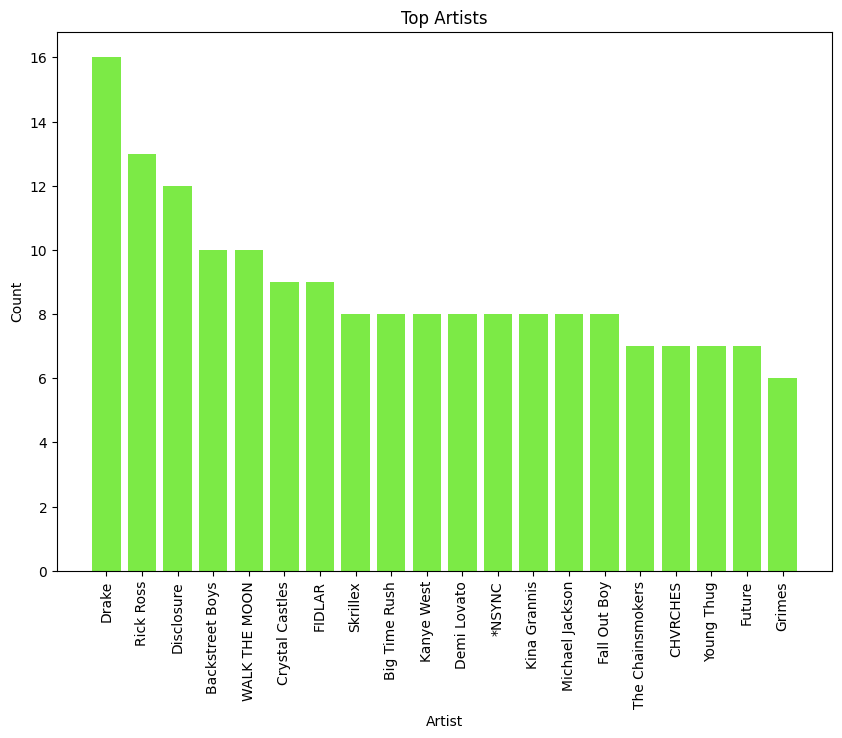

In [12]:
# Set the title and axis labels
values = data['artist'].value_counts().tolist()[:20]
names = list(dict(data['artist'].value_counts()).keys())[:20]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 7))  # smaller figsize
ax.bar(names, values, color="#7CEA46")

# Set the title and axis labels
ax.set_title("Top Artists")
ax.set_xlabel("Artist")
ax.set_ylabel("Count")

# Display the plot
plt.xticks(rotation=90)
plt.show()


We split the data to `numeric` and `categorical` :

In [13]:
# Categorical data
categorical_data = data.select_dtypes(include=['object'])
print("Categorical columns: ", categorical_data.columns.tolist())

# Numeric data
numeric_data = data.select_dtypes(include=['int64', 'float64'])
print("Numeric columns: ", numeric_data.columns.tolist())


Categorical columns:  ['song_title', 'artist']
Numeric columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


We print the **Correlation Matrix** of the dataset to find the correlation between the attributes. The ones with the higher correlation are the ones that we need to check because they will probably be important for the analysis.

In [1]:
# Plot linear correlation matrix
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.1g', cmap="red_r", cbar=False)
plt.title('Linear Correlation Matrix')
plt.show()

NameError: name 'plt' is not defined

We notice that the correlation between energy-loudness is really high and between acousticness-loudness and acousticness-energy is really low.

In [14]:
# Check absolute correlation
corr_df = numeric_data.corr('spearman').stack().reset_index(name='corr')
corr_df.loc[corr_df['corr'] == 1, 'corr'] = 0  # Remove diagonal
corr_df['abs'] = corr_df['corr'].abs()
alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='abs',
    color=alt.Color('corr', scale=alt.Scale(scheme='blueorange', domain=(-1, 1)))
).properties(
    title={'text': 'Absolute Correlation', 'fontSize': 15},
    width=300,  
    height=300  
)



alt.Chart(...)

Based on the `Absolute Correlation` we make find the pairs of attributes that are more correlated with each other.
We see that the most correlated attributes are:
* energy-loudness 
* acousticness-loudness 
* acousticness-energy 
* danceability - valence




We use **heatmap** to review the correlation more clearly. We notice that there are some pairs that have larger absolute correlation than most of the others such as : 
* *loudness* and *energy*, 
* *acousticness* and *energy*, 
* *valence* and *danceability*

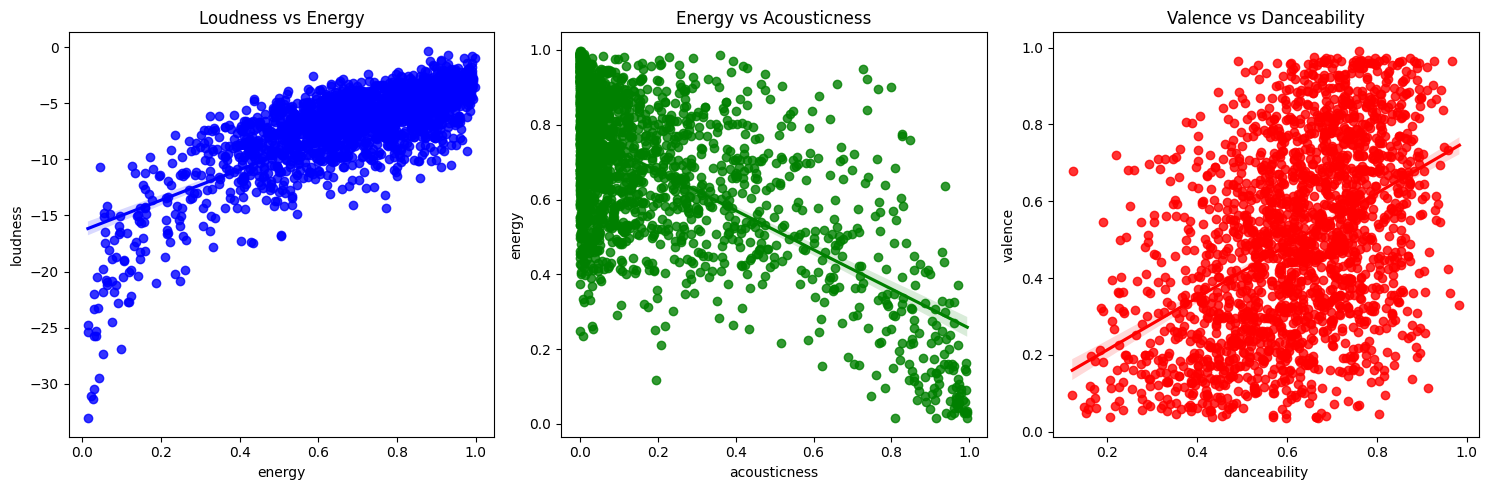

In [15]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Scatter chart for "loudness" and "energy"
sns.regplot(ax=axes[0], y='loudness', x='energy', data=data, color='blue')
axes[0].set_title('Loudness vs Energy')

# Scatter chart for "acousticness" and "energy"
sns.regplot(ax=axes[1], y='energy', x='acousticness', data=data, color='green')
axes[1].set_title('Energy vs Acousticness')

# Scatter chart for "valence" and "danceability"
sns.regplot(ax=axes[2], y='valence', x='danceability', data=data, color='red')
axes[2].set_title('Valence vs Danceability')

# Make the layout tight
plt.tight_layout()
plt.show()


For `loudness` and `energy` we see a tight correlation because most of the points are close to the line of correlation.

For `energy` and `acousticness` we don't see a good correlation because most of the points are close to zero.

For ` danceability` and `valence` we also don't notice a good correlation because points are not close to the correlation line.

So we create a new attribute about `loudness` and `energy` , maybe their ration value is going to play an important role in our analysis because of their strong correlation

In [16]:
# Create new attributes
data['energy_loudness_ratio'] = data['energy'] / data['loudness']
# Append the new features to numeric_data
numeric_data = pd.concat([numeric_data, data[['energy_loudness_ratio']]], axis=1)

data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'song_title',
       'artist', 'energy_loudness_ratio'],
      dtype='object')

We print **Histograms** for all the numeric columns to check the values of each attribute

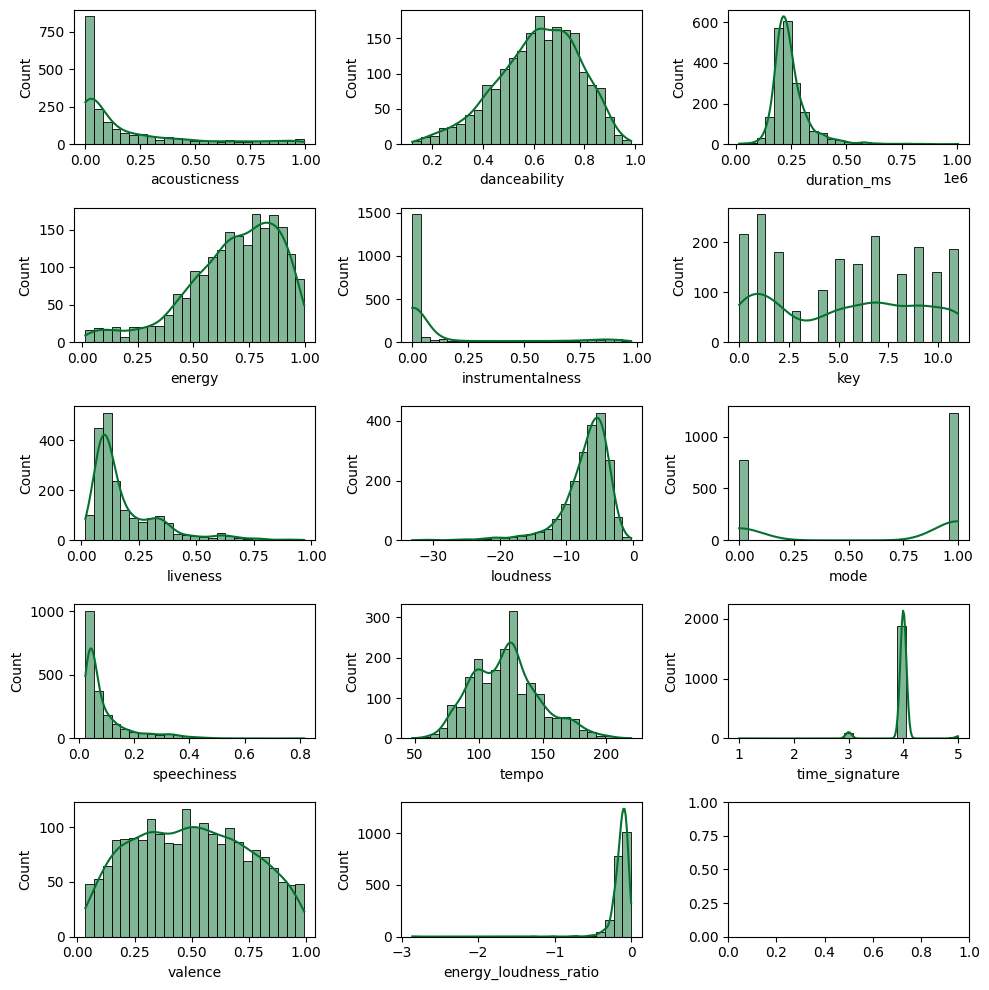

In [17]:
sns.set_palette("Greens_r")
num_cols = data.select_dtypes(include="number").columns
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
axes = axes.flatten()
ax_no = 0
for col in num_cols:
    sns.histplot(data=data, x=col, bins=25, kde=True, ax=axes[ax_no])
    ax_no += 1
plt.tight_layout()  # Adjust the layout to prevent overlapping labels
plt.show()

<a id="subsection2-two"></a>
## *Data Pre-Processing*

We clean the data so we feed only the important variables on the model

We notice that some attributes such as `mode`, `time_signature` don't have different values between the different songs on the dataset so they are not defined characteristics that we need for our analysis.

In [18]:
data.drop('mode', axis=1, inplace=True)
data.drop('time_signature', axis=1, inplace=True)

We also split our numerical datas to `continuous` and `discrete` columns to continue with our analysis

In [19]:
# Continuous Columns
continuous_cols = ['acousticness', 'danceability', 'duration_ms', 'energy',
                   'liveness', 'loudness', 'tempo', 'valence', 'speechiness', 'instrumentalness','energy_loudness_ratio']

# Discrete Columns
discrete_cols = ['key']

We **scale** the `continuous` data of the dataset :

In [20]:
# Create a StandardScaler object
scaler = StandardScaler()
# Apply scaling to the numeric features
scaled_features = scaler.fit_transform(numeric_data[continuous_cols])

# Create a new DataFrame with the scaled numeric features
data[continuous_cols] = pd.DataFrame(scaled_features, columns=data[continuous_cols].columns)

We perform **One-Hot Encoding** for the `discrete` data in our dataset.

In [21]:
# Perform one-hot encoding
one_hot_encoded_data = pd.get_dummies(data, columns=discrete_cols, drop_first=True)
data = pd.concat([data.drop(columns=discrete_cols), one_hot_encoded_data], axis=1)

# Check for duplicate columns
duplicate_columns = data.columns[data.columns.duplicated()]

# Drop duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

data = data.dropna()

# Numeric Data
numeric_data = data.select_dtypes(include=[np.number])

numeric_data.columns

# Print the DataFrame after dropping duplicate columns
print(data.columns)

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'song_title', 'artist', 'energy_loudness_ratio', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11'],
      dtype='object')


<a id="subsection2-three"></a>
## 2.3. *Principal Components Analysis (PCA)*

We performs **Principal Component Analysis (PCA)**, a dimensionality reduction technique, on a dataset containing numerical variables. It aims to identify the most influential features in the dataset that explain the most variance. 

We keep 15 components, then we fits the PCA model to the data, retrieves the explained variance for each component, and identifies the indices of the 15 components with the highest explained variance. 

Then we provide an overview of the most significant attributes in the dataset according to the PCA model.





In [22]:
n_components = 11  # Number of components to keep

pca = PCA(n_components=n_components)
pca.fit(numeric_data)
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the components with the highest explained variance in descending order
top_components_indices = np.argsort(explained_variance_ratio)[::-1][:n_components]

# Get the corresponding column names
sorted_attributes_pca = [numeric_data.columns[i] for i in top_components_indices]

# Create a DataFrame with the sorted attributes from PCA
final_attributes_pca = pd.DataFrame({'Attributes': sorted_attributes_pca})

# Print the final DataFrame
print(final_attributes_pca)

               Attributes
0            acousticness
1            danceability
2             duration_ms
3                  energy
4        instrumentalness
5                liveness
6                loudness
7             speechiness
8                   tempo
9                 valence
10  energy_loudness_ratio


We then proceed to keep the **10 most important** attributes of the dataset:

In [23]:
# Get the top 10 attributes from PCA
pca_top_attributes = sorted_attributes_pca[:10]

# Get the 8 attributes with the highest importance based on their position in the combined list
final_attributes = pca_top_attributes[:10]

# Print the final attributes
for attribute in final_attributes:
    print(attribute)

acousticness
danceability
duration_ms
energy
instrumentalness
liveness
loudness
speechiness
tempo
valence


We create the `new_data` frame with only the most important attributes:

In [24]:
# Select the relevant columns from numeric_data
pca_data = numeric_data[final_attributes]

# Add the 'artist' and 'song_title' columns from the data DataFrame
pca_data.insert(0, 'song_title', data['song_title'])
pca_data.insert(1, 'artist', data['artist'])

new_data = pca_data.dropna()
new_data.head()

,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Mask Off,Future,-0.683353,1.334474,-0.507172,-1.179686,-0.407484,-0.165313,-0.457888,3.805626,1.066550,-0.855352
1,Redbone,Childish Gambino,0.043461,0.775291,0.984749,-1.536441,-0.465311,-0.345553,-0.885268,-0.144439,1.442258,0.367042
2,Xanny Family,Future,-0.590191,1.365539,-0.737583,-1.284334,-0.486830,-0.203936,-0.019597,2.210321,-1.746028,-1.312737
3,Master Of None,Beach House,1.602569,-0.771781,-0.570430,-1.636332,1.380040,-0.633936,-2.171933,-0.743240,-1.317719,-1.082021
4,Parallel Lines,Junior Boys,-0.029682,0.371437,1.789169,-0.575581,1.387364,1.598462,-1.217113,-0.256784,1.964185,1.646103


In [46]:
new_data.to_csv('SongDataset.csv', index=False) 

In [25]:
# Perform PCA for dimensional reduction
n_components = 10  # Number of components to keep
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(new_data.iloc[:, 2:])  # Exclude 'song_title' and 'artist' columns

# Convert the reduced_data back to a DataFrame
reduced_data_pca = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])
reduced_data_pca.insert(0, 'song_title', pca_data['song_title'])
reduced_data_pca.insert(1, 'artist', pca_data['artist'])
reduced_data_pca = reduced_data_pca.dropna()
reduced_data_pca.head()

,song_title,artist,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,Mask Off,Future,-0.377790,-0.819423,-1.488999,3.634478,-0.704745,1.415111,-0.589508,-1.128672,0.376105,-0.384681
1,Redbone,Childish Gambino,1.002715,-0.800291,0.004221,0.750283,-1.264797,-0.488989,1.448783,-0.839400,0.509487,-0.418384
2,Xanny Family,Future,0.146192,-1.381900,-0.793918,1.506959,1.382646,2.231148,-1.019401,-1.123041,0.065210,-0.567266
3,Master Of None,Beach House,3.699711,-0.155546,-0.462886,-0.727139,0.497671,0.052561,-1.341354,-0.041816,0.246766,0.283453
4,Parallel Lines,Junior Boys,0.758668,0.413775,1.910776,1.613494,-1.115955,-2.555866,0.869719,-0.239347,0.757377,-0.288095


As we can see the previous columns have been replaced with the columns that PCA generated.

<a id="section-three"></a>
# **Model Development**

In [26]:
# Assume df is your DataFrame and 'song_title' and 'artist_name' are your columns
user_input = input("\n     Enter a song title:     \n").strip().lower()

# Convert the 'song_title' column to lower case
reduced_data_pca['song_title'] = reduced_data_pca['song_title'].str.lower()
reduced_data_pca['artist'] = reduced_data_pca['artist'].str.lower()

# Search in the lower case column
matched_songs = reduced_data_pca[reduced_data_pca['song_title'] == user_input]

if len(matched_songs) > 1:
    print("Multiple songs with that title found. Please specify the artist.")
    user_input_artist = input("Enter an artist name: ").strip().lower()
    
    # Create the 'artist_name_lower' column in the 'matched_songs' DataFrame
    matched_songs['artist'] = matched_songs['artist'].str.lower()
    
    matched_songs = matched_songs[matched_songs['artist'] == user_input_artist]
    matched_songs.drop(columns=['song_title', 'artist'], inplace=True)

elif len(matched_songs) == 1:
    print("Song found!")
    matched_songs.drop(columns=['song_title'], inplace=True)
    
else:
    print("Song not found.")


Song found!


<a id="subsection3two-one"></a>
## **K-Means Clustering**

In [27]:
# Perform clustering using KMeans algorithm
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(reduced_data_pca.iloc[:, 2:].values)

# Add the cluster labels as a new column in the reduced_data DataFrame
reduced_data_pca['cluster_label_kmeans'] = cluster_labels_kmeans

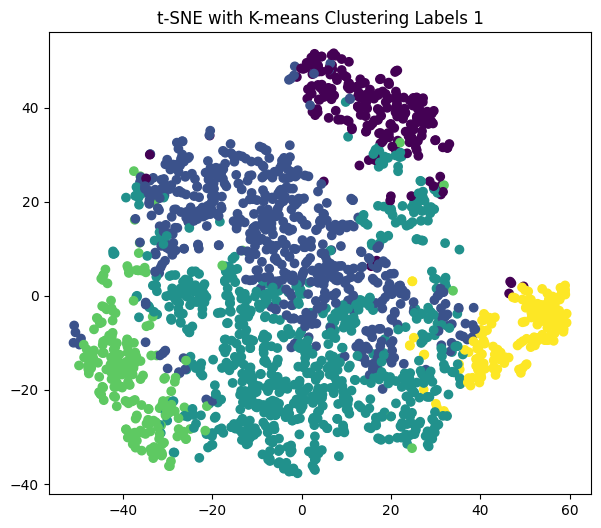

In [28]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_Kmeans': reduced_data_pca['cluster_label_kmeans'],
})

# Visualize K-means clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_Kmeans'], cmap='viridis')
plt.title('t-SNE with K-means Clustering Labels 1')
plt.show()

In [29]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

Silhouette Coefficient: 0.16003084033874115
Calinski-Harabasz Index: 327.83802230592016


In [30]:
# Perform clustering using KMeans algorithm
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(reduced_data_pca.iloc[:, 2:-2].values)

# Add the cluster labels as a new column in the reduced_data DataFrame
reduced_data_pca['cluster_label_kmeans'] = cluster_labels_kmeans


In [31]:
reduced_data_pca.to_csv('labelled.csv', index=False) 


<a id="section-four"></a>
# **EVALUATION**


<a id="subsection4-one"></a>
##  *Similarity Metrics*

* **Euclidean Similarity** : Euclidean similarity, also known as Euclidean distance, measures the similarity or dissimilarity between two data points based on their geometric distance in a multi-dimensional space. It calculates the straight-line distance between the points using the Euclidean distance formula. The formula calculates the square root of the sum of squared differences between corresponding features of the two points. A smaller Euclidean distance indicates a higher similarity between the points.
    Euclidean similarity considers the magnitude and direction of the feature values. It works well when the data points are represented as vectors in a continuous numerical space. However, it may not be suitable for high-dimensional and sparse data, where the curse of dimensionality and feature sparsity can affect the distance calculation.

* **Cosine Similarity** : Cosine similarity measures the similarity between two data points by calculating the cosine of the angle between their feature vectors. It disregards the magnitude of the vectors and focuses on the direction or orientation of the vectors in the multi-dimensional space. It is commonly used when the data points represent documents or texts, and the similarity is based on the occurrence or frequency of words.

    Cosine similarity is calculated by taking the dot product of the feature vectors and dividing it by the product of their magnitudes. The resulting value ranges from -1 to 1, where 1 represents perfect similarity, 0 indicates no similarity, and -1 indicates perfect dissimilarity. Cosine similarity is robust to differences in magnitude and is particularly useful when comparing the similarity between sparse vectors.

Both `Euclidean similarity` and `Cosine similarity` have their own applications and use cases. The choice between them depends on the nature of the data and the specific problem at hand.

We perform them both on K-Means Algorithm to check which one is more suitable in our case.

### Cosine Similarity 


In [32]:
def cosine_similarity_kmeans(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = reduced_data_pca[reduced_data_pca['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_kmeans']

    # Get the songs within the user song's cluster
    cluster_data = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = cosine_similarity([user_features], cluster_data.iloc[:, 2:-1])[0]

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

In [33]:
def cosine_similarity_dbscan(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = reduced_data_pca[reduced_data_pca['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_dbscan']

    # Get the songs within the user song's cluster
    cluster_data = reduced_data_pca[reduced_data_pca['cluster_label_dbscan'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = cosine_similarity([user_features], cluster_data.iloc[:, 2:-1])[0]

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

In [34]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [35]:
# Example usage
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)

            song_title        artist  similarity
0             mask off        future  100.000000
2         xanny family        future  100.000000
776     temporary view        sbtrkt   96.490368
148              river         ibeyi   92.650583
924       muzik xpress     x-press 2   90.997475
154          big rings         drake   90.939634
355        nimble girl    hotel eden   90.846921
872  oogum boogum song  brenton wood   90.743829
982              weary       solange   90.156387
201              mercy    kanye west   89.878638


## Eucledian similarity

In [36]:
def euclidean_similarity_kmeans(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = reduced_data_pca[reduced_data_pca['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_kmeans']

    # Get the songs within the user song's cluster
    cluster_data = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = []
    for _, song in cluster_data.iterrows():
        similarity = 1 / (1 + euclidean(user_features, song[2:-1]))
        similarity_scores.append(similarity)

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores = np.array(similarity_scores)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices


In [37]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = euclidean_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [38]:
# Example usage
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)

            song_title        artist  similarity
0             mask off        future  100.000000
2         xanny family        future  100.000000
776     temporary view        sbtrkt   44.978950
924       muzik xpress     x-press 2   34.663440
355        nimble girl    hotel eden   34.231231
872  oogum boogum song  brenton wood   33.776666
148              river         ibeyi   32.591158
201              mercy    kanye west   32.569884
552          nightcall      kavinsky   32.042980
456      computer love          zapp   31.805672


In [39]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_dbscan(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_dbscan(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_dbscan'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_dbscan'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [40]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]
